In [1]:
import yfinance as yf
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pandasgui import show
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow import keras
from sklearn.preprocessing import Normalizer

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
dfImputado = pd.read_csv('infoImputadaVer2.csv')

In [3]:
correlacionAbsolutaMarkCap = abs(dfImputado.corr()['marketCap']).sort_values()

In [4]:
columnasCorrelacionadas = list(correlacionAbsolutaMarkCap[correlacionAbsolutaMarkCap>0.1].index)
columnasCorrelacionadas.append('symbol')
dfImputado = dfImputado[(columnasCorrelacionadas)]

In [570]:
dfImputado

,trailingAnnualDividendYield,operatingMargins,grossMargins,profitMargins,bid,totalCash,shortRatio,52WeekChange,returnOnAssets,shortPercentOfFloat,...,grossProfits,sharesOutstanding,freeCashflow,floatShares,netIncomeToCommon,operatingCashflow,ebitda,enterpriseValue,marketCap,symbol
0,0.062149,0.14962,0.42547,0.16314,0.00,3.969000e+09,4.01,-0.343942,0.06742,0.0216,...,1.500000e+10,5.516720e+08,3.498250e+09,5.512254e+08,5.454000e+09,5.855000e+09,6.840000e+09,6.601763e+10,5.150962e+10,MMM
1,0.017394,0.17624,0.36394,0.06487,0.00,4.960000e+08,4.33,0.103408,0.12177,0.0429,...,1.329600e+09,1.245380e+08,3.090125e+08,1.223000e+08,2.428000e+08,4.948000e+08,7.354000e+08,9.912247e+09,9.626784e+09,AOS
2,0.019270,0.18000,0.55639,0.13984,0.00,9.532000e+09,2.63,-0.116180,0.06318,0.0075,...,2.457900e+10,1.738950e+09,6.409875e+09,1.725748e+09,5.776000e+09,8.659000e+09,1.072100e+10,1.845843e+11,1.756687e+11,ABT
3,0.042363,0.36979,0.70959,0.13368,0.00,6.722000e+09,2.20,-0.065607,0.09443,0.0068,...,4.152700e+10,1.764290e+09,2.160288e+10,1.761537e+09,7.542000e+09,2.422800e+10,2.952300e+10,2.984637e+11,2.425370e+11,ABBV
4,0.014039,0.15288,0.32120,0.10990,0.00,6.242976e+09,3.87,0.032747,0.13110,0.0136,...,1.970154e+10,6.315320e+08,8.329611e+09,6.306292e+08,6.939801e+09,9.680274e+09,1.069959e+10,1.924437e+11,1.935059e+11,ACN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.013655,0.31787,0.48501,0.17666,0.00,3.730000e+08,2.08,0.070089,0.23843,0.0111,...,3.307000e+09,2.800870e+08,7.075000e+08,2.796416e+08,1.226000e+09,1.523000e+09,2.344000e+09,4.849009e+10,3.558785e+10,YUM
494,0.000000,0.16597,0.46124,0.07091,262.59,1.090000e+08,2.74,-0.199581,0.08776,0.0227,...,2.624000e+09,5.143030e+07,7.526250e+08,5.105747e+07,4.080000e+08,3.580000e+08,1.151000e+09,1.579364e+10,1.351511e+10,ZBRA
495,0.007593,0.19864,0.71576,0.06327,0.00,3.302000e+08,1.85,0.059943,0.04118,0.0165,...,4.920400e+09,2.097980e+08,1.391900e+09,2.082648e+08,4.497000e+08,1.355200e+09,2.336300e+09,3.228097e+10,2.640098e+10,ZBH
496,0.055690,0.39581,0.00000,0.29243,27.28,4.403000e+09,1.99,-0.483750,0.01010,0.1304,...,3.030000e+09,1.481010e+08,5.514846e+08,1.456230e+08,8.740000e+08,1.403000e+09,1.331308e+09,1.389759e+10,4.040935e+09,ZION


In [5]:
nombres = dfImputado[['symbol']]
marketCap = dfImputado[['marketCap']]
logMarketCap = np.log2(marketCap)
minMarketCap = marketCap.min()
normalizedMarketCap = (marketCap - minMarketCap)
newMaxMarkCap = normalizedMarketCap.max()
normalizedMarketCap = normalizedMarketCap/newMaxMarkCap * 1000
marketCapReducidoLineal = marketCap/10e8
dfImputadoX =dfImputado.drop(['symbol', 'marketCap' ], axis=1)

In [6]:
dfImputadoXNormalizado=(dfImputadoX-dfImputadoX.mean())/dfImputadoX.std()


In [573]:
dfImputadoXNormalizado

,trailingAnnualDividendYield,operatingMargins,grossMargins,profitMargins,bid,totalCash,shortRatio,52WeekChange,returnOnAssets,shortPercentOfFloat,...,totalRevenue,impliedSharesOutstanding,grossProfits,sharesOutstanding,freeCashflow,floatShares,netIncomeToCommon,operatingCashflow,ebitda,enterpriseValue
0,2.042112,-0.380038,-0.019555,0.200857,-0.388000,-0.118098,0.487308,-1.233895,-0.016062,-0.263980,...,0.029161,-0.054628,0.135220,-0.087153,0.123753,-0.075337,0.276376,0.051137,0.066227,-0.080431
1,-0.177328,-0.184672,-0.285815,-0.456245,-0.388000,-0.151547,0.659953,0.487520,0.964127,0.470721,...,-0.450615,-0.054628,-0.451987,-0.427277,-0.324070,-0.394202,-0.367996,-0.431334,-0.444462,-0.337575
2,-0.084267,-0.157077,0.546978,0.045057,-0.388000,-0.064520,-0.257223,-0.357461,-0.092529,-0.750331,...,0.159640,-0.054628,0.546682,0.858270,0.532594,0.797810,0.316192,0.303525,0.390898,0.462986
3,1.060915,1.235811,1.209924,0.003867,-0.388000,-0.091583,-0.489214,-0.162857,0.471057,-0.774476,...,0.405860,-0.054628,1.274676,0.878448,2.665945,0.824416,0.534560,1.704888,1.963807,0.984920
4,-0.343709,-0.356113,-0.470765,-0.155143,-0.388000,-0.096197,0.411776,0.215615,1.132391,-0.539924,...,0.509341,-0.054628,0.337172,-0.023561,0.802157,-0.016307,0.460097,0.395449,0.389108,0.499007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,-0.362734,0.854765,0.238094,0.291262,-0.388000,-0.152732,-0.553956,0.359306,3.068061,-0.626156,...,-0.398944,-0.054628,-0.367048,-0.303415,-0.268115,-0.277233,-0.246422,-0.338786,-0.309892,-0.160764
494,-1.039912,-0.260044,0.135233,-0.415858,1.230098,-0.155274,-0.197876,-0.678392,0.350765,-0.226038,...,-0.418110,-0.054628,-0.396386,-0.485493,-0.261779,-0.447164,-0.347569,-0.443647,-0.409694,-0.310619
495,-0.663359,-0.020276,1.236624,-0.466944,-0.388000,-0.153144,-0.678045,0.320265,-0.489293,-0.439894,...,-0.396234,-0.054628,-0.297745,-0.359385,-0.172014,-0.330295,-0.342413,-0.353889,-0.310536,-0.235054
496,1.721823,1.426774,-1.860701,1.065382,-0.219898,-0.113918,-0.602513,-1.771880,-1.049813,3.488858,...,-0.460919,-0.054628,-0.378947,-0.408514,-0.290022,-0.376864,-0.289948,-0.349587,-0.394610,-0.319309


In [574]:
X_train, X_test, y_train, y_test = train_test_split(dfImputadoXNormalizado, marketCapReducidoLineal, test_size=0.2, random_state=42)

In [575]:
modelo = keras.Sequential(
    [keras.layers.Dense(81, activation = "relu"), #Para el input 81 neuronas
    keras.layers.Dense(20, activation = "relu"), 
    keras.layers.Dense(10, activation = "relu"), 
    keras.layers.Dense(5, activation = "relu"), 
    keras.layers.Dense(3, activation = "relu"), 
    keras.layers.Dense(1, activation = "relu")] #Para el output una sola neurona
)

In [576]:
modelo.compile(loss="mape", metrics=["mae", "mse"], optimizer="adam")

In [577]:
historial = modelo.fit(dfImputadoXNormalizado, normalizedMarketCap,epochs=500)

Epoch 1/500
16/16 [==============================] - 3s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1035
Epoch 2/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1040
Epoch 3/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1035
Epoch 4/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1035
Epoch 5/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1040
Epoch 6/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1040
Epoch 7/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1040
Epoch 8/500
16/16 [==============================] - 0s 3ms/step - loss: 99.7992 - mae: 25.8143 - mse: 6524.1040
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 99.7992 - mae: 25.8143 

KeyboardInterrupt: 

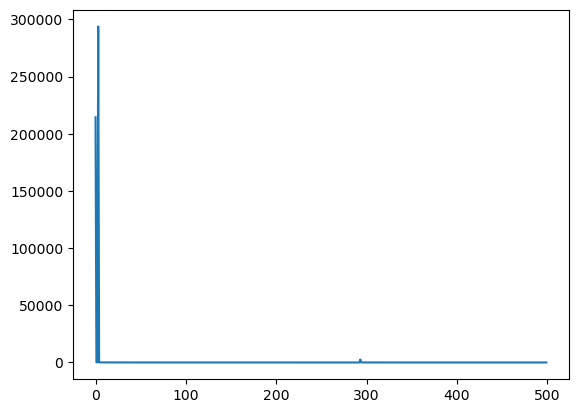

In [43]:
plt.plot(historial.history["loss"])

In [36]:
y_pred = modelo.predict(dfImputadoXNormalizado)


16/16 [==============================] - 0s 1ms/step


In [38]:
marketCapPredicho = ((y_pred / 1000) * float(newMaxMarkCap)) + float(minMarketCap)

In [39]:
dfNormImpCopia = dfImputadoXNormalizado.copy()
dfNormImpCopia.insert(0, 'marketCap', marketCap)
dfNormImpCopia.insert(0, 'marketCapPredNN', marketCapPredicho)
dfNormImpCopia.insert(0, 'symbol', nombres)

In [44]:
show(dfNormImpCopia)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


(array([263., 107.,  39.,  23.,  13.,  14.,   3.,   5.,   3.,   2.,   4.,
          1.,   4.,   1.,   1.,   1.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.54716928e+09, 3.20400548e+10, 6.05329408e+10, 8.90258309e+10,
        1.17518713e+11, 1.46011603e+11, 1.74504493e+11, 2.02997367e+11,
        2.31490257e+11, 2.59983147e+11, 2.88476037e+11, 3.16968927e+11,
        3.45461817e+11, 3.73954707e+11, 4.02447565e+11, 4.30940455e+11,
        4.59433345e+11, 4.8792

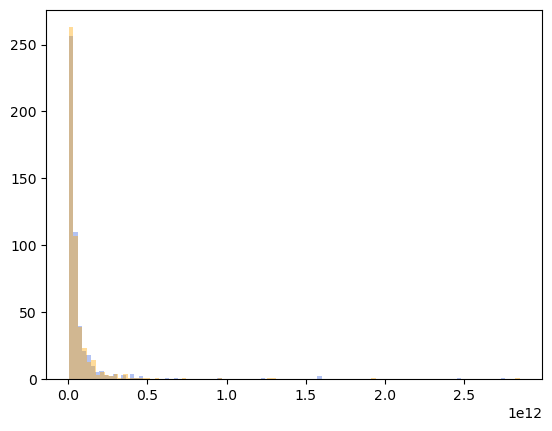

In [41]:
plt.hist(marketCap, bins=100, alpha=0.4, color="royalblue")
plt.hist(marketCapPredicho, bins=100, alpha=0.4, color="orange")

In [42]:
dfNormImpCopia.to_csv('prediccionesMarketCapSinValidarNN.csv') 

In [7]:
nombresYmarketCap = dfImputado[['symbol', 'marketCap']]

dfImputadoX =dfImputado.drop(['symbol', 'marketCap' ], axis=1)
dfImputadoXNorm=(dfImputadoX-dfImputadoX.mean())/dfImputadoX.std()
dfImputadoXNorm.insert(0, 'symbol', nombresYmarketCap['symbol'])
dfImputadoXNorm.insert(0, 'marketCap', nombresYmarketCap['marketCap'])

dfTrain = dfImputadoXNorm[((dfImputadoXNorm['symbol']!='GOOGL') & (dfImputadoXNorm['symbol']!='XOM') &
                    (dfImputadoXNorm['symbol']!='JNJ'))]
dfTest = dfImputadoXNorm[((dfImputadoXNorm['symbol']=='GOOGL') | (dfImputadoXNorm['symbol']=='XOM') |
                    (dfImputadoXNorm['symbol']=='JNJ'))]


In [8]:
dfTrainX = dfTrain.drop(['symbol', 'marketCap' ], axis=1)#.to_numpy()
dfTestX = dfTest.drop(['symbol', 'marketCap' ], axis=1)#.to_numpy()
dfTrainY = dfTrain[['symbol', 'marketCap' ]]
dfTestY = dfTest[['symbol', 'marketCap' ]]

In [9]:
dfTest

,marketCap,symbol,trailingAnnualDividendYield,operatingMargins,grossMargins,profitMargins,bid,totalCash,shortRatio,52WeekChange,...,totalRevenue,impliedSharesOutstanding,grossProfits,sharesOutstanding,freeCashflow,floatShares,netIncomeToCommon,operatingCashflow,ebitda,enterpriseValue
22,1.571076e+12,GOOGL,-1.039912,0.382714,0.532395,0.486446,0.372646,0.952242,-0.839899,0.419968,...,4.088343,-0.054628,6.219005,4.204338,7.476588,7.662074,6.846347,7.615833,6.813623,6.476078
189,4.144459e+11,XOM,0.666512,-0.060054,-0.371410,0.145291,-0.388000,0.158143,-0.516190,0.333447,...,5.927815,-0.054628,5.234572,2.692955,5.959420,2.516098,7.230037,6.576399,7.430004,1.637811
266,4.012889e+11,JNJ,0.412132,0.505644,1.037740,-0.006163,-0.388000,0.080728,-0.548561,-0.415788,...,1.044550,-0.054628,2.238018,1.542907,1.528991,1.444339,1.175322,1.366811,2.263130,1.585070


In [581]:
show(dfTrainX)

PandasGUI INFO — pandasgui.gui — Opening PandasGUI


In [41]:
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0, sigma=100, shape=35)

    # model error
    sigma = pm.Exponential("sigma", lam=1/1000)

    # matrix-dot products
    m1 = pm.math.matrix_dot(dfTrainX, betas)
    intercept = pm.Exponential('intercept', lam=1/1000)

    # Likelihood: normal
    y = pm.Normal("y",
                  mu=m1 + intercept,
                  sigma=sigma,
                  observed=(dfTrainY['marketCap']/10e8)
                  )

    trace = pm.sample(3000, tune=1500)

C:\Users\fridm\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, sigma, betas]


Sampling 4 chains for 1_500 tune and 3_000 draw iterations (6_000 + 12_000 draws total) took 2707 seconds.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 1314 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum 

C:\Users\fridm\AppData\Local\Temp\ipykernel_24860\488324252.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\fridm\anaconda3\lib\site-packages\arviz\utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be chang

<Figure size 700x700 with 0 Axes>

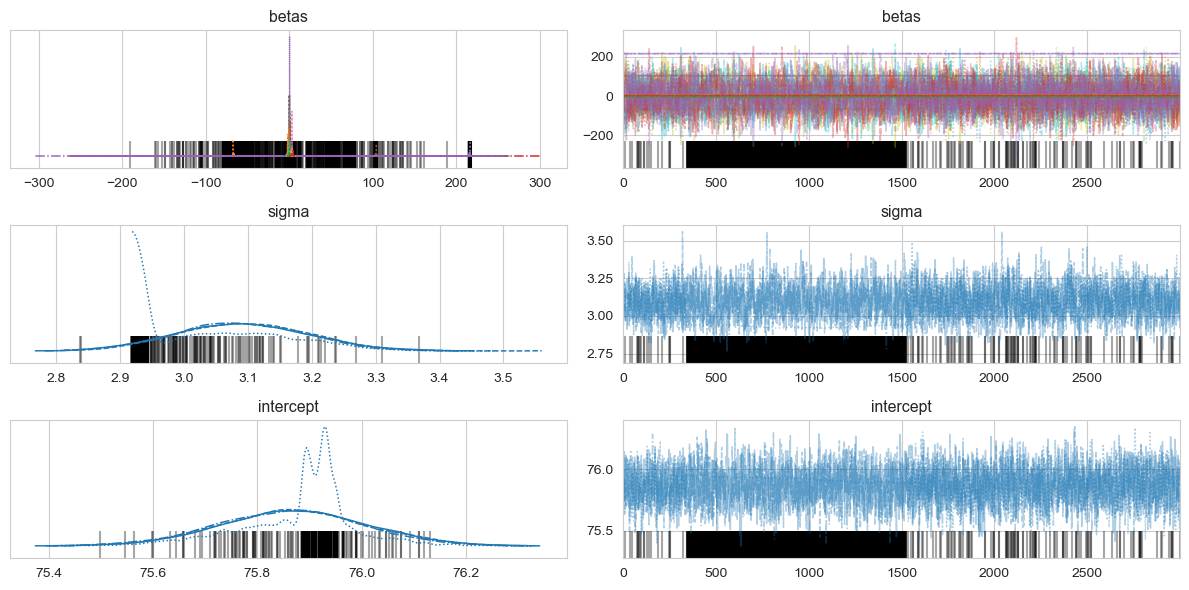

In [42]:
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace)
plt.tight_layout()

In [585]:
import pickle


#pickle.dump(trace, open("trace35variablesNorm.pkl", "wb"))

In [11]:
import pickle

tracePicleada = pickle.load(open("trace35variablesNorm.pkl", "rb"))


In [43]:
tracePicleada = trace

In [44]:
tracePicleada['betas'].shape

(12000, 35)

In [45]:
tracePicleada['betas'][0]

array([-3.31541441e-01,  4.27499814e-01,  6.91957985e-01, -3.27641510e-01,
        4.15961862e-01,  1.02572175e+02,  6.33335336e-01, -5.36783826e-02,
       -5.55511617e-01,  4.71524659e-01, -9.82669295e-01, -6.61693544e+01,
       -6.53381793e-01,  8.88128285e-02,  7.70633070e-04, -2.10491953e-01,
       -3.94816650e-01, -3.49204969e-01, -1.17948946e+00,  1.46152947e+00,
       -4.12203942e-01,  7.18345083e-02,  3.18586487e+00, -2.23568402e+00,
       -5.82613892e-01,  1.04491646e+00,  3.23350331e+00, -1.32685552e+00,
        2.12071182e+00,  7.10905471e-02, -9.86030792e-01, -1.44398870e-01,
       -1.12471225e+00,  1.55211215e+00,  2.15906902e+02])

In [46]:
datosTestGoogle = dfTestX.loc[[22]].to_numpy()
datosTestExxon = dfTestX.loc[[189]].to_numpy()
datosTestJhonson = dfTestX.loc[[266]].to_numpy()

In [47]:
datosTestGoogle

array([[-1.03991155,  0.38271407,  0.53239521,  0.48644645,  0.37264606,
         0.95224219, -0.83989918,  0.41996785,  1.00704975, -0.68479434,
         0.21348053,  0.10692676, -0.95615531, -1.47941066,  0.48360305,
        -0.46164486,  0.96951048,  2.08231908,  1.52773411,  1.52773411,
         3.05082115,  3.37330163,  3.02799448,  3.12565159,  3.12565159,
         4.08834315, -0.05462753,  6.21900521,  4.20433785,  7.47658761,
         7.66207394,  6.84634713,  7.61583298,  6.81362338,  6.4760782 ]])

In [48]:
def giveOneMarketCapBayesianEstimationForMean(xData, singleBetaSample, singleInterceptSample):
    return((xData*singleBetaSample).sum()+singleInterceptSample)

In [49]:
giveOneMarketCapBayesianEstimationForMean(datosTestGoogle , tracePicleada['betas'][2], tracePicleada['intercept'][2])

1558.098167954092

In [50]:
def giveManyMarketCapBayesianEstimation(xData, betas, sigmas, intercepts):
    marketCapPosteriorSamples = []

    for i in range(0, len(betas)):
        meanSample = giveOneMarketCapBayesianEstimationForMean(xData, betas[i], intercepts[i] )
        sigmaSample = sigmas[i]
        
        sample = np.random.normal(meanSample,sigmaSample, size=1)[0]
        while(sample<0):
            sample = np.random.normal(meanSample,sigmaSample, size=1)[0]
        marketCapPosteriorSamples.append(sample)
        
    return(np.array(marketCapPosteriorSamples))

In [63]:
marketCapExxonPosteriorSamples = giveManyMarketCapBayesianEstimation(datosTestExxon,
                                                                   tracePicleada['betas'], 
                                                                   tracePicleada['sigma'], 
                                                                   tracePicleada['intercept'])*10e8
marketCapGooglePosteriorSamples = giveManyMarketCapBayesianEstimation(datosTestGoogle,
                                                                   tracePicleada['betas'], 
                                                                   tracePicleada['sigma'], 
                                                                   tracePicleada['intercept'])*10e8
marketCapJhonsonPosteriorSamples = giveManyMarketCapBayesianEstimation(datosTestJhonson,
                                                                   tracePicleada['betas'], 
                                                                   tracePicleada['sigma'], 
                                                                   tracePicleada['intercept'])*10e8

In [64]:
valorizacionMercadoGoogle = dfTestY.loc[[22]]['marketCap'].to_numpy()[0]
valorizacionMercadoExxon = dfTestY.loc[[189]]['marketCap'].to_numpy()[0]
valorizacionMercadoJhonson = dfTestY.loc[[266]]['marketCap'].to_numpy()[0]

In [53]:
valorizacionMercadoExxon

414445895680.0

Text(0.5, 1.0, 'Exxon')

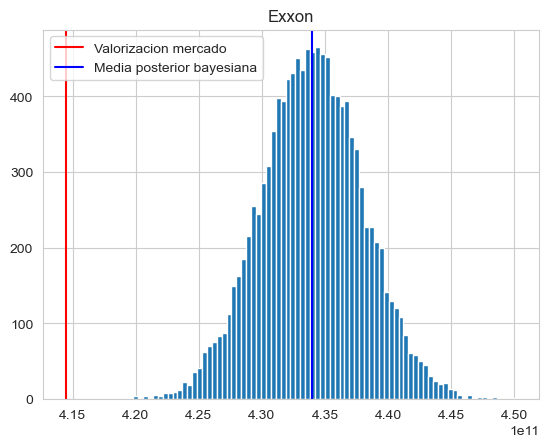

In [66]:
plt.hist(marketCapExxonPosteriorSamples, bins=80)
plt.axvline(x = valorizacionMercadoExxon, color = 'r', label = 'axvline - full height')
plt.axvline(x = marketCapExxonPosteriorSamples.mean(), color = 'b', label = 'axvline - full height')
plt.legend(["Valorizacion mercado","Media posterior bayesiana"])
plt.title(label='Exxon')

Text(0.5, 1.0, 'Google MarkCap Posterior')

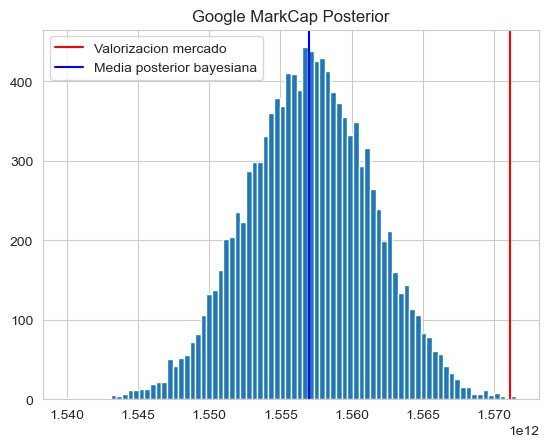

In [67]:
plt.hist(marketCapGooglePosteriorSamples, bins=80)
plt.axvline(x = valorizacionMercadoGoogle, color = 'r', label = 'axvline - full height')
plt.axvline(x = marketCapGooglePosteriorSamples.mean(), color = 'b', label = 'axvline - full height')
plt.legend(["Valorizacion mercado","Media posterior bayesiana"])

plt.title(label='Google MarkCap Posterior')

Text(0.5, 1.0, 'Jhonson & Jhonson')

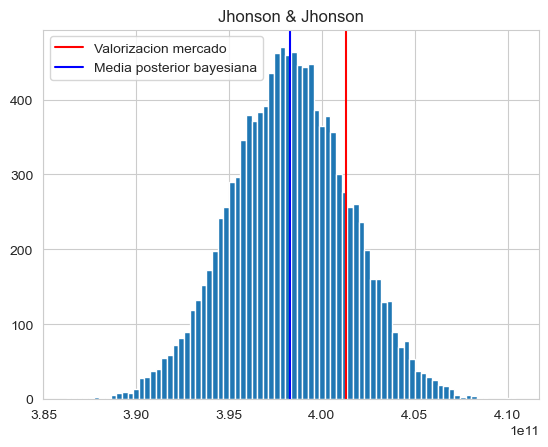

In [56]:
plt.hist(marketCapJhonsonPosteriorSamples, bins=80)
plt.axvline(x = valorizacionMercadoJhonson, color = 'r', label = 'axvline - full height')
plt.axvline(x = marketCapJhonsonPosteriorSamples.mean(), color = 'b', label = 'axvline - full height')
plt.legend(["Valorizacion mercado","Media posterior bayesiana"])
plt.title(label='Jhonson & Jhonson')

In [57]:
def precios(symbol):
    print('as')
    tickerSymbol = symbol
    data = yf.Ticker(tickerSymbol)
    info = data.info

    cantidad = float(info['sharesOutstanding'])
    print(info['marketCap'])
    prices = data.history(start='2023-01-01', end='2023-05-30').Close
    returns = prices.pct_change().dropna()

    return(prices*cantidad)

In [58]:
exxonPrices2=precios('XOM')

as
413111713792


In [59]:
exxonPrices2

Date
2023-01-03 00:00:00-05:00    4.236534e+11
2023-01-04 00:00:00-05:00    4.248864e+11
2023-01-05 00:00:00-05:00    4.343929e+11
2023-01-06 00:00:00-05:00    4.396432e+11
2023-01-09 00:00:00-05:00    4.314494e+11
                                 ...     
2023-05-22 00:00:00-04:00    4.243916e+11
2023-05-23 00:00:00-04:00    4.301731e+11
2023-05-24 00:00:00-04:00    4.349842e+11
2023-05-25 00:00:00-04:00    4.271813e+11
2023-05-26 00:00:00-04:00    4.243916e+11
Name: Close, Length: 101, dtype: float64

In [560]:
31498676224.0/414850187264


0.07592783417006162

In [60]:
exxonPrices = exxonPrices2

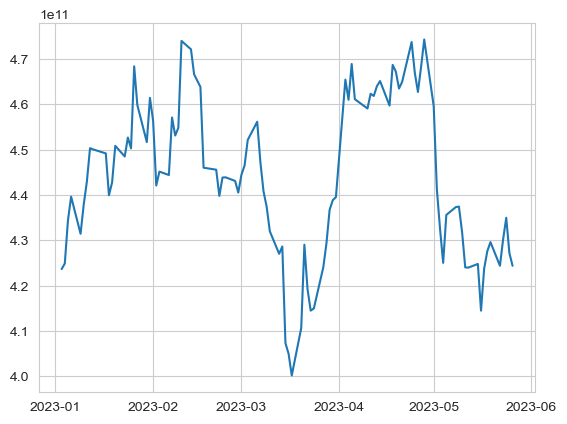

In [61]:
plt.plot(exxonPrices)
plt.show()

In [618]:
exxonPrices

C:\Users\fridm\AppData\Local\Temp\ipykernel_24860\3922659365.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(np.array(exxonPrices), shade=True, color="r")
C:\Users\fridm\AppData\Local\Temp\ipykernel_24860\3922659365.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(np.array(marketCapExxonPosteriorSamples), shade=True, color="b")


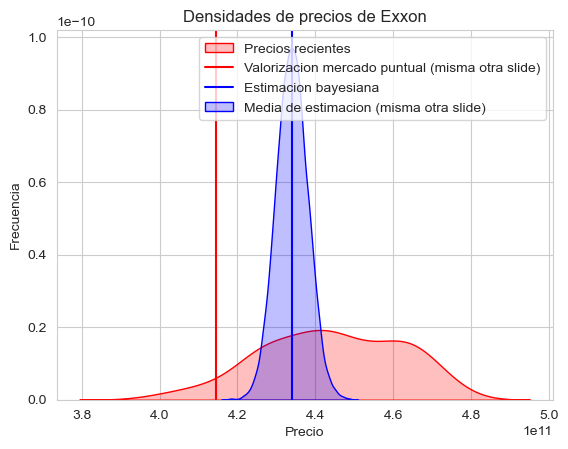

In [62]:
sns.set_style('whitegrid')
fig = sns.kdeplot(np.array(exxonPrices), shade=True, color="r")
plt.axvline(x = valorizacionMercadoExxon, color = 'r', label = 'axvline - full height')
plt.axvline(x = marketCapExxonPosteriorSamples.mean(), color = 'b', label = 'axvline - full height')

fig = sns.kdeplot(np.array(marketCapExxonPosteriorSamples), shade=True, color="b")
plt.title('Densidades de precios de Exxon')
plt.ylabel('Frecuencia')
plt.xlabel('Precio')
plt.legend(["Precios recientes","Valorizacion mercado puntual (misma otra slide)", 'Estimacion bayesiana','Media de estimacion (misma otra slide)'])

plt.show()


In [610]:
exxonPrices